In [1]:
import pandas as pd
import numpy as np

In [2]:
import sympy as sp

In [3]:
import seaborn as sns

In [4]:
from scipy import stats

In [5]:
from numba import jit

# Overview

Given a trading system model $F_{t}(\theta)$, the goal is to adjust the parameters $\theta$ in order to maximise $U_{t}$ (wealth).

# $$ \frac{dU_{T}(\theta)}{d\theta} = 
\sum \limits _{t=1} ^ {T} 
\frac{dU_{T}}{dR_{t}} 
\{ \frac{dR_{t}}{dF_{t}} \frac{dF_{t}}{d\theta} + \frac{dR_{t}}{dF_{t-1}} \frac{dF_{t-1}}{d\theta}  \}$$

Where:
* $U$ = wealth function (Sharpe ratio / Sterling ratio)
* $R_{t}$ = realised returns 
* $r_{t}$ = asset returns
* $F_{t}$ = position  
* $\theta$ = model weights
* $\delta$ = transaction costs
* $\mu$ = max position (multiplied by $F_{t}$ which goes from -1 to 1)

#### References

* J. Moody and M. Saffell, "Learning to trade via direct reinforcement," in IEEE Transactions on Neural Networks, vol. 12, no. 4, pp. 875-889, July 2001, doi: 10.1109/72.935097.

* https://teddykoker.com/2019/06/trading-with-reinforcement-learning-in-python-part-ii-application/
* http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf

#### Load derivative functions from standalone notebook

In [6]:
%run 3_reinforcement_trading_offline_simple_derivs.ipynb

-----

In [7]:
NUM_RETURNS = M = 8

## Calculate positions based on $tanh(\theta \cdot state)$

State takes the form: $[1, R_{t}, R_{t-1}, ..., R_{t-M}, F_{t-1}]$ 

In [8]:
def positions(r, theta):
    '''
    Apply weights to state to determine positisons
    '''
    
    T = len(r)
    Ft = np.zeros(T)
    for t in range(M, T):
        state = np.concatenate([ [1], r[t - M:t], [Ft[t-1]] ])
        Ft[t] = np.tanh(np.dot(theta, state))
        
    return Ft

#### TODO: returns are based on zscores, fees are absolute

In [9]:
def returns(Ft, r, delta):
    '''
    Calculate realised returns based on positions and fees
    '''
    T = len(r)
    R = (Ft[0:T-1] * r[1:T]) - delta * (np.abs(Ft[1:T] - Ft[0:T-1]))
    return np.concatenate((np.array([0]), R))

-----

In [21]:
def gradient(rets, theta, delta, moving_avg_n):
    Ft = positions(rets, theta) 
    R = returns(Ft, rets, delta) 
   
    # I don't think i need to calc this for all time here, 
    # just N where n = (1/N)
    A = get_A(R, moving_avg_n)
    DD2 = get_DD2(R, moving_avg_n)
    
    return _gradient(rets, theta, R, Ft, A, DD2, delta), DDR(R[:-1], R[:1])
    
def _gradient(rets, theta, R, Ft, A, DD2, delta):
    T = len(rets)
    grad = np.zeros(M + 2)
    dFtdTheta_prev = np.zeros(M + 2)
    
    for t in range(M, T):
        state = np.concatenate( (np.array([1]), rets[t - M:t], np.array([Ft[t-1]]) ))
        
        # Derivative functions are defined in 3_reinforcement_trading_simple_derivs.ipynb
        dRdFt = get_dRdFt(delta, Ft, t)

        dFtdTheta = get_dFtdTheta(Ft, t, state, theta, dFtdTheta_prev)
        
        dRdFtp = get_dRdFtp(rets, delta, Ft, t)

        dUdR = ddr_auto(R[min(t-25, 0):t], R[t])#get_dUdR(A, t, R, DD2)
        
        inner = ((dRdFt*dFtdTheta) + (dRdFtp*dFtdTheta_prev))

        grad_delta = dUdR * inner
        grad = grad + np.nan_to_num(grad_delta)
        
        dFtdTheta_prev = dFtdTheta
  
    return grad

## Main

In [22]:
epochs = 250
tick_sample_n = 700
lr = 0.05
best_weights = np.zeros(M+2)
delta = 0.02

moving_avg_n = 1/10

In [23]:
df = pd.read_csv('~/Downloads/coinbaseGBP.csv', 
             names=['_dt', 'price', 'size'])

df['dt'] = pd.to_datetime(df['_dt'],unit='s')
df = df.set_index('dt').drop(columns=['_dt'])

df['ret'] = np.log(df.price) - np.log(df.price.shift(1))

df = df.tail(tick_sample_n)

display('{} -> {}'.format(df.index[0], df.index[-1]))

# TODO: Rolling Z-Score
rets_z = stats.zscore(df.ret.values)
rets = np.tanh(rets_z/3)

'2019-01-07 19:57:30 -> 2019-01-07 22:05:22'

In [24]:
def xavier_weights_init(n):
    return (np.random.randn(1, n) * np.sqrt(1/(n-1)))[0]

theta = xavier_weights_init(M+2)
theta

array([ 0.03550669,  0.04026647, -0.14444841, -0.5487993 , -0.32584427,
       -0.12545008, -0.12036871,  0.14900055, -0.59143941, -0.1591881 ])

In [25]:
%%time

loss_history = []
for i in range(0, epochs):
    g, loss = gradient(rets, theta, delta, moving_avg_n)
    theta = theta + (lr * g)
    
    loss_history.append(loss)
    if loss == max(loss_history):
        best_theta = theta
        
    if i % 10 == 0:
        print('loss: {}'.format(loss))
        
theta = best_theta

loss: -0.0289749838411808
loss: 0.09169968217611313
loss: 0.15329015254974365
loss: 0.1782471239566803
loss: 0.19290967285633087
loss: 0.18377934396266937
loss: 0.19171522557735443
loss: 0.17331057786941528
loss: 0.16738010942935944
loss: 0.1719541698694229
loss: 0.1744432896375656
loss: 0.17604510486125946
loss: 0.1774604469537735
loss: 0.17787235975265503
loss: 0.1795313060283661
loss: 0.18026413023471832
loss: 0.17961430549621582
loss: 0.18104977905750275
loss: 0.18060219287872314
loss: 0.1823214590549469
loss: 0.18232767283916473
loss: 0.1847740262746811
loss: 0.1850517988204956
loss: 0.18591716885566711
loss: 0.18640828132629395
CPU times: user 3min 13s, sys: 22.4 s, total: 3min 35s
Wall time: 3min 15s


### Loss

In [26]:
loss_history = [l.item() for l in loss_history]

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

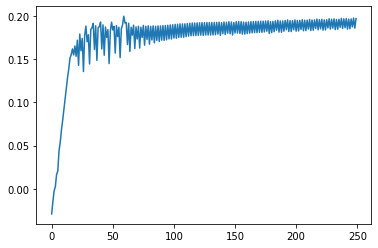

In [27]:
sns.lineplot(range(0, len(loss_history)), loss_history)

### Returns

<AxesSubplot:>

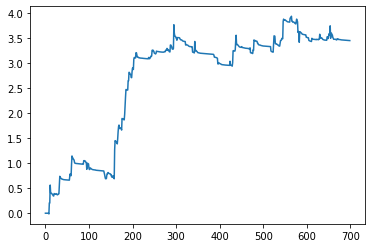

In [28]:
Ft = positions(rets, theta)
Rt = returns(Ft, rets, delta)

# TODO: These are zscores of log returns, convert back to normal returns
realised_returns = returns(Ft, rets, delta)
pd.Series(realised_returns).cumsum().plot()

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

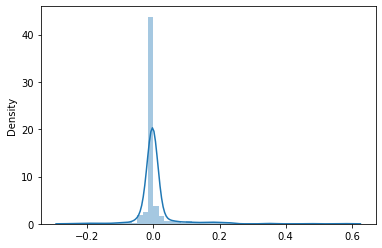

In [29]:
sns.distplot(realised_returns)

### Positions

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

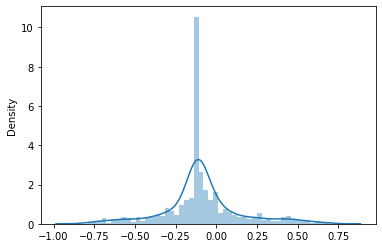

In [30]:
sns.distplot(Ft)